In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('out_LED.csv')

In [3]:
# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ].copy()

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

In [4]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [5]:
# convert response poke from [2,3] to [-1,1]
df['response_poke'] = 2*df['response_poke'] - 5

# Aborts cenered on LED on set

In [6]:
# led_trial = 0 in df
df_1 = df [ df['LED_trial'] == 1 ]
df_0 = df [ df['LED_trial'] == 0 ]

In [7]:
abort_wrt_led_onset_led_on = []
for idx, row in tqdm(df_1.iterrows(), total=len(df_1)):
    if row['timed_fix'] > 0.3:
        if row['timed_fix'] < row['intended_fix']:
            abort_wrt_led_onset_led_on.append(row['timed_fix'] - row['LED_onset_time'])

abort_wrt_led_onset_led_off = []
for idx, row in tqdm(df_0.iterrows(), total=len(df_0)):
    if row['timed_fix'] > 0.3:
        if row['timed_fix'] < row['intended_fix']:
            abort_wrt_led_onset_led_off.append(row['timed_fix'] - row['LED_onset_time'])

  0%|          | 0/34025 [00:00<?, ?it/s]

100%|██████████| 66226/66226 [00:01<00:00, 45954.32it/s]


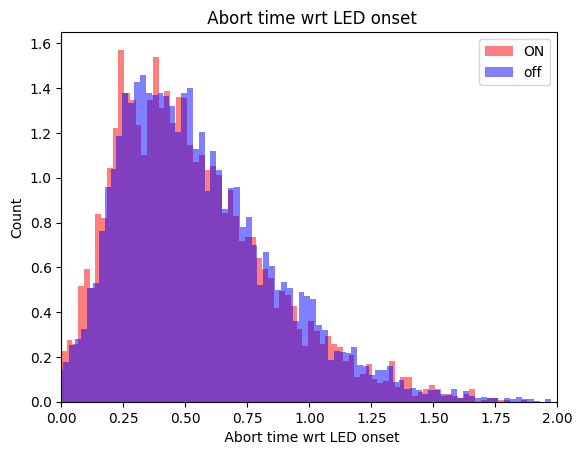

In [8]:
plt.hist(abort_wrt_led_onset_led_on, bins=100, alpha=0.5, color='r', label='ON', density=True)
plt.hist(abort_wrt_led_onset_led_off, bins=100, alpha=0.5, label='off', color='b', density=True)
plt.xlabel(' Abort time wrt LED onset')
plt.ylabel('Count')
plt.title(' Abort time wrt LED onset')
plt.axvline(x=0, color='r');
plt.legend();
plt.xlim(0, 2);

In [9]:
# In df, find unique LED_onset_time
LED_onset_time_arr = df['LED_onset_time'].unique()

diff_btn_aborts = []

for t in LED_onset_time_arr:
    
    # find rows with LED_onset_time in df_1
    df_1_t = df_1[ df_1['LED_onset_time'].isin([t]) ]
    df_0_t = df_0[ df_0['LED_onset_time'].isin([t]) ]

    # df_1_t timed_fix where timed_fix < intended_fix
    df_1_t_aborts = df_1_t[ df_1_t['timed_fix'] < df_1_t['intended_fix'] ]
    df_0_t_aborts = df_0_t[ df_0_t['timed_fix'] < df_0_t['intended_fix'] ]

    #  truncate t > 0.3
    df_1_t_aborts = df_1_t_aborts[ df_1_t_aborts['timed_fix'] > 0.3 ]
    df_0_t_aborts = df_0_t_aborts[ df_0_t_aborts['timed_fix'] > 0.3 ]

    # aborts wrt LED onset
    aborts_wrt_LED_onset_1 = df_1_t_aborts['timed_fix'] - df_1_t_aborts['LED_onset_time']
    aborts_wrt_LED_onset_0 = df_0_t_aborts['timed_fix'] - df_0_t_aborts['LED_onset_time']

    # mean of on - mean of off
    mean_aborts_1 = np.mean( aborts_wrt_LED_onset_1 )
    mean_aborts_0 = np.mean( aborts_wrt_LED_onset_0 )

    # if any of them are nan, skip
    if np.isnan(mean_aborts_1) or np.isnan(mean_aborts_0):
        continue

    diff_btn_aborts.append( mean_aborts_1 - mean_aborts_0 )

    

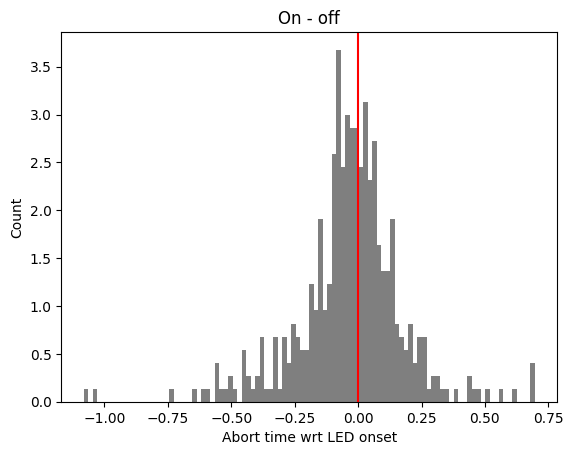

In [10]:
plt.hist(diff_btn_aborts, bins=100, alpha=0.5, color='k', density=True)
plt.title('On - off')
plt.xlabel('Abort time wrt LED onset')
plt.ylabel('Count')
plt.axvline(x=0, color='r');

# Pscyhometric funcs

In [11]:
# correct and trials dict init
num_RHS_LED_on_dict = {}
num_trials_LED_on_dict = {}

num_RHS_LED_off_dict = {}
num_trials_LED_off_dict = {}

for ABL in ABL_arr:
    num_RHS_LED_on_dict[ABL] = np.zeros_like(ILD_arr)
    num_trials_LED_on_dict[ABL] = np.zeros_like(ILD_arr)

    num_RHS_LED_off_dict[ABL] = np.zeros_like(ILD_arr)
    num_trials_LED_off_dict[ABL] = np.zeros_like(ILD_arr)


# iteratre for each row of df
for index, row in tqdm(df.iterrows()):
    ABL = row['ABL']
    ILD = row['ILD']
    response_poke = row['response_poke']
    LED_trial = row['LED_trial']

    if np.isnan(response_poke):
        continue
    if LED_trial == 1:
        num_trials_LED_on_dict[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
        if response_poke == 1:
            num_RHS_LED_on_dict[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
    else:
        num_trials_LED_off_dict[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
        if response_poke == 1:
            num_RHS_LED_off_dict[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

100251it [00:02, 36488.10it/s]


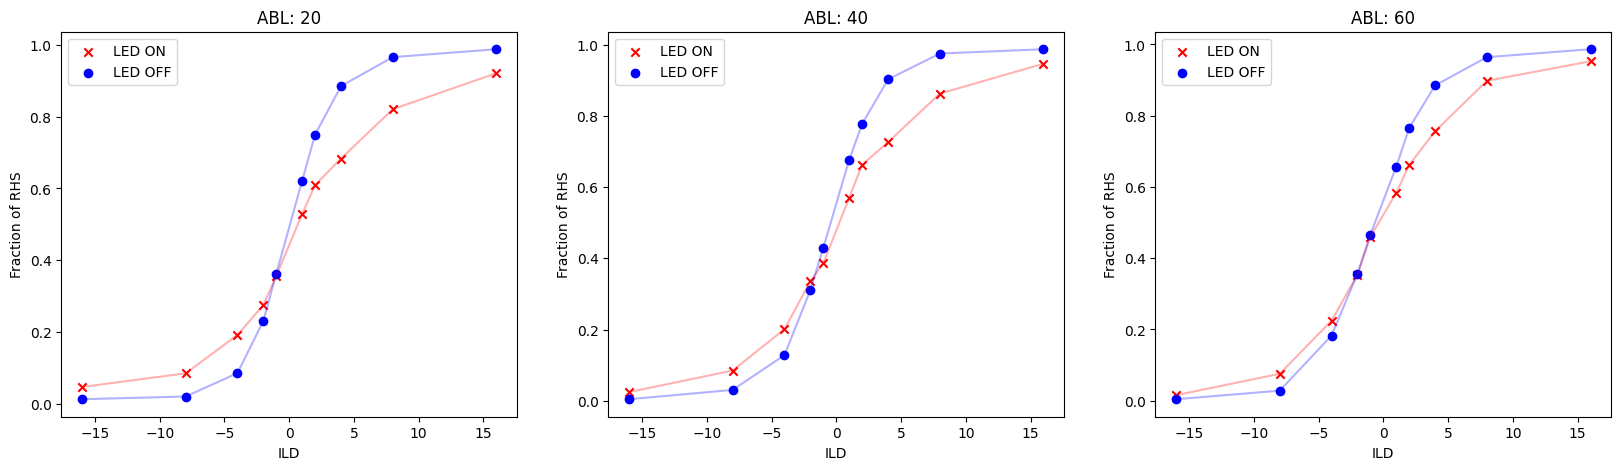

In [12]:
# for each ABL plot fraction of correct 
plt.figure(figsize=(20,5))
for i, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), i+1)
    plt.scatter(ILD_arr, num_RHS_LED_on_dict[ABL]/num_trials_LED_on_dict[ABL], label='LED ON', color='red', marker='x')
    plt.plot(ILD_arr, num_RHS_LED_on_dict[ABL]/num_trials_LED_on_dict[ABL], color='red', alpha=0.3)

    plt.scatter(ILD_arr, num_RHS_LED_off_dict[ABL]/num_trials_LED_off_dict[ABL], label='LED OFF', color='b', marker='o')
    plt.plot(ILD_arr, num_RHS_LED_off_dict[ABL]/num_trials_LED_off_dict[ABL], color='b', alpha=0.3)
    plt.xlabel('ILD'); plt.ylabel('Fraction of RHS'); plt.title('ABL: '+str(ABL));
    plt.legend()


# Percentiles

In [13]:
rt_LED_on_per_ABL_dict = {}
rt_LED_off_per_ABL_dict = {}

for ABL in ABL_arr:
    rt_LED_on_per_ABL_dict[ABL] = {ILD:[] for ILD in ILD_arr}
    rt_LED_off_per_ABL_dict[ABL] = {ILD:[] for ILD in ILD_arr}


for index, row in tqdm(df.iterrows()):
    ABL = row['ABL']
    ILD = row['ILD']
    
    intended_fix = row['intended_fix']
    timed_fix = row['timed_fix']

    LED_trial = row['LED_trial']

    if np.isnan(intended_fix) or np.isnan(timed_fix):
        continue

    rt = timed_fix - intended_fix        


    if LED_trial == 1:
        rt_LED_on_per_ABL_dict[ABL][ILD].append(rt)
    else:
        rt_LED_off_per_ABL_dict[ABL][ILD].append(rt)

100251it [00:02, 33911.21it/s]


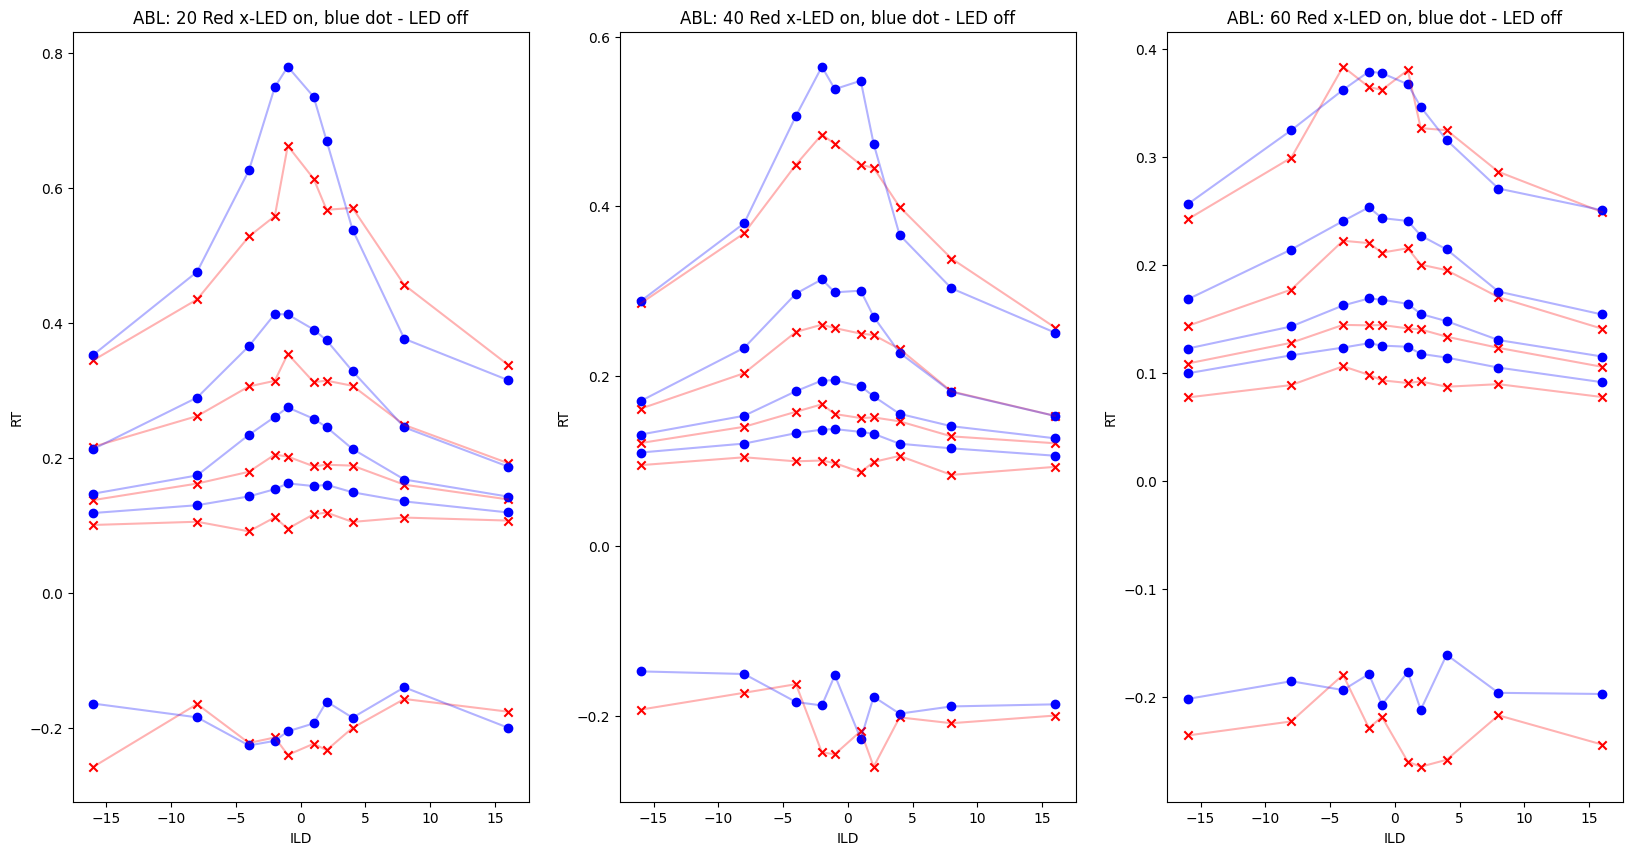

In [14]:
percentiles = [10, 30, 50, 70, 90]
plt.figure(figsize=(20,10))
for a, ABL in enumerate(ABL_arr):
    percentiles_LED_on = np.zeros((len(ILD_arr), len(percentiles)))
    percentiles_LED_off = np.zeros((len(ILD_arr), len(percentiles)))

    for i, ILD in enumerate(ILD_arr):
        if len(rt_LED_on_per_ABL_dict[ABL][ILD]) == 0:
            percentiles_LED_on[i] = np.nan
            print(f'ILD = {ILD} and ABL = {ABL} has no LED on trials')
        else:
            percentiles_LED_on[i] = np.percentile(rt_LED_on_per_ABL_dict[ABL][ILD], percentiles)

        
        if len(rt_LED_off_per_ABL_dict[ABL][ILD]) == 0:
            percentiles_LED_off[i] = np.nan
            print(f'ILD = {ILD} and ABL = {ABL} has no LED off trials')
        else:
            percentiles_LED_off[i] = np.percentile(rt_LED_off_per_ABL_dict[ABL][ILD], percentiles)

    plt.subplot(1, len(ABL_arr), a+1)
    for j, percentile in enumerate(percentiles):
        plt.scatter(ILD_arr, percentiles_LED_on[:,j], color='red', marker='x', label='LED on')
        plt.plot(ILD_arr, percentiles_LED_on[:,j], color='red',alpha=0.3)

        plt.scatter(ILD_arr, percentiles_LED_off[:,j], color='blue', marker='o', label='LED off')   
        plt.plot(ILD_arr, percentiles_LED_off[:,j], color='blue', alpha=0.3)
    
    plt.title(f'ABL: {str(ABL)} Red x-LED on, blue dot - LED off'); plt.xlabel('ILD'); plt.ylabel('RT'); 
    

# RTD disrributions

In [16]:
led_on_after_light = df_1[ (df_1['timed_fix'] > df_1['LED_onset_time']) ]
led_on_rt_wrt_stim = (led_on_after_light['timed_fix'] - led_on_after_light['intended_fix']).values

led_off_after_light = df_0[ (df_0['timed_fix'] > df_0['LED_onset_time']) ]
led_off_rt_wrt_stim = (led_off_after_light['timed_fix'] - led_off_after_light['intended_fix']).values

 num of off aborts: 8552/62878 = 0.13600941505773084
num of on aborts: 5319/30471 = 0.17455941715073348


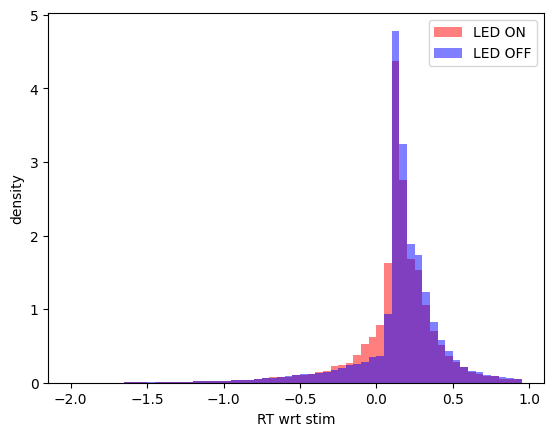

In [19]:
plt.hist(led_on_rt_wrt_stim, bins=np.arange(-2, 1, 0.05), alpha=0.5, color='r', label='LED ON', density=True)
plt.hist(led_off_rt_wrt_stim, bins=np.arange(-2, 1, 0.05), alpha=0.5, color='b', label='LED OFF', density=True)
plt.xlabel('RT wrt stim')
plt.ylabel('density')
plt.legend();

# num of led_off_after_light < 0
print(f' num of off aborts: {np.sum(led_off_rt_wrt_stim < 0)}/{len(led_off_rt_wrt_stim)} = {np.sum(led_off_rt_wrt_stim < 0)/len(led_off_rt_wrt_stim)}')
print(f'num of on aborts: {np.sum(led_on_rt_wrt_stim < 0)}/{len(led_on_rt_wrt_stim)} = {np.sum(led_on_rt_wrt_stim < 0)/len(led_on_rt_wrt_stim)}')